CG-Vec

Crystal Grpahs (CG) Construction

In [7]:
import csv, functools, json, warnings, re
import os, random
import numpy as np
import torch
from torch.utils.data import Dataset
from pymatgen.core import Element, Structure, Lattice
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

class GaussianDistance(object):
    def __init__(self, dmin, dmax, step, var=None):
        assert dmin < dmax
        assert dmax - dmin > step
        self.filter = np.arange(dmin, dmax + step, step)
        self.var = step if var is None else var

    def expand(self, distances):
        return np.exp(-(distances[..., np.newaxis] - self.filter) ** 2 / self.var ** 2)


class CIFData(Dataset):
    def __init__(self, id_prop_path, magmom_path, eigen_path, ofm_val_comp_path,
             max_num_nbr=12, radius=8, dmin=0, step=0.1, random_seed=123):


        # Load CSV
        with open(id_prop_path) as f:
            reader = csv.reader(f)
            self.id_prop_data = [row for row in reader]

        # Load magnetic moments
        with open(magmom_path) as f:
            self.magmom = json.load(f)

        # Load magnetic moments
        with open(eigen_path) as f:
            self.eigen1 = json.load(f)

        # Load magnetic moments
        with open(ofm_val_comp_path) as f:
            self.ofm_val_comp = json.load(f)

        random.seed(random_seed)
        random.shuffle(self.id_prop_data)

        self.gdf = GaussianDistance(dmin=dmin, dmax=radius, step=step)
        self.max_num_nbr = max_num_nbr
        self.radius = radius

    def __len__(self):
        return len(self.id_prop_data)

    def structure_from_str(self, cif_string):
        cif_lines = cif_string.strip().split('\n')

    # Parse lattice
        a, b, c = map(float, cif_lines[2].split()[2:5])
        alpha, beta, gamma = map(float, cif_lines[3].split()[1:4])

        species, coords = [], []

        reading_atoms = False
        for line in cif_lines:
            line = line.strip()
            if re.match(r'^\d+\s+\w+\s+[\d\.Ee+-]+\s+[\d\.Ee+-]+\s+[\d\.Ee+-]+', line):
                reading_atoms = True
            if not reading_atoms:
                continue
            try:
                parts = line.split()
                if len(parts) < 5:
                    continue
                sp = parts[1]
                a_frac, b_frac, c_frac = map(float, parts[2:5])
                species.append(sp)
                coords.append([a_frac, b_frac, c_frac])
            except Exception as e:
                warnings.warn(f"Skipping line due to error: {line} ({e})")
                continue

        lattice = Lattice.from_parameters(a, b, c, alpha, beta, gamma)
        return Structure(lattice, species, coords)


    def featurizer(self, element):
        min_max = [[1.00794, 244.0], [1.0, 118.0], [0.25, 2.6], [-0.72, 3.61272528]]
        lis = ['Atomic mass', 'Atomic no', 'Atomic radius', 'Electron affinity']
        ele = Element(element)
        try:
            fea = [float(str(ele.data[i]).split()[0]) for i in lis]
        except:
            fea = [ele.data['Atomic mass'], ele.data['Atomic no'],
                   ele.data['Atomic radius calculated'], ele.data['Electron affinity']]
        for i in range(4):
            fea[i] = (fea[i] - min_max[i][0]) / (min_max[i][1] - min_max[i][0])
        return fea

    @functools.lru_cache(maxsize=None)
    def __getitem__(self, idx):
        cif_id, cif_string, target = self.id_prop_data[idx]
        crystal = self.structure_from_str(cif_string)

        atom_fea = np.vstack([
            [self.magmom[site.species_string]] + self.ofm_val_comp[site.species_string]
            + self.featurizer(site.species_string)
            for site in crystal
        ])
        atom_fea = torch.Tensor(atom_fea)

        all_nbrs = crystal.get_all_neighbors(self.radius, include_index=True)
        all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]
        nbr_fea_idx, nbr_fea = [], []

        for i, nbr in enumerate(all_nbrs):
            if len(nbr) < self.max_num_nbr:
                warnings.warn(f'{cif_id} atom {i} has only {len(nbr)} neighbors. Consider increasing radius.')
                nbr_fea_idx.append([x[2] for x in nbr] + [0] * (self.max_num_nbr - len(nbr)))
                nbr_fea.append([x[1] for x in nbr] + [self.radius + 1.] * (self.max_num_nbr - len(nbr)))
            else:
                nbr_fea_idx.append([x[2] for x in nbr[:self.max_num_nbr]])
                nbr_fea.append([x[1] for x in nbr[:self.max_num_nbr]])

        nbr_fea_idx = torch.LongTensor(nbr_fea_idx)
        nbr_fea = torch.Tensor(self.gdf.expand(np.array(nbr_fea)))
        target = torch.Tensor([float(target)])
        return (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id



CG to Vector

In [8]:
# Add this function below your CIFData class
def graph_to_vector(atom_fea, nbr_fea):
    """
    Robust pooling: uses unbiased=False to avoid ddof warning when N_atoms == 1.
    """
    N = atom_fea.shape[0]
    if N == 0:
        raise ValueError("Empty structure with zero atoms.")
    atom_mean = atom_fea.mean(dim=0)
    # use biased estimator (ddof=0) — stable for N=1
    atom_std = atom_fea.std(dim=0, unbiased=False)
    # or explicitly set zeros for single-atom
    # atom_std = atom_fea.std(dim=0, unbiased=False) if N>1 else torch.zeros_like(atom_mean)

    # edges: if no neighbors, guard similarly
    if nbr_fea.numel() == 0:
        # D_edge needs to be inferred-safe
        D_edge = 0
        edge_mean = torch.zeros(0)
        edge_std = torch.zeros(0)
    else:
        edge_mean = nbr_fea.mean(dim=(0,1))
        edge_std = nbr_fea.std(dim=(0,1), unbiased=False)

    return torch.cat([atom_mean, atom_std, edge_mean, edge_std], dim=0)


# Example usage:
dataset = CIFData(id_prop_path="my_new_data1/co_fm.csv", magmom_path="my_new_data1/magmom.json", eigen_path="my_new_data1/eigenvalues_bulk.json",
                   ofm_val_comp_path="my_new_data1/ofm.json")
(graph_data, target, cif_id) = dataset[0]
atom_fea, nbr_fea, nbr_fea_idx = graph_data

fixed_vector = graph_to_vector(atom_fea, nbr_fea)
print("Graph vector shape:", fixed_vector.shape)
print("Graph vector:", fixed_vector)

X = []
y = []      
for (atom_fea, nbr_fea, _), target, cif_id in dataset:
    graph_vec = graph_to_vector(atom_fea, nbr_fea)
    X.append(graph_vec.numpy())  # convert tensor to numpy
    y.append(target.item())      # scalar target



Graph vector shape: torch.Size([236])
Graph vector: tensor([2.8230e+00, 0.0000e+00, 1.0000e+00, 1.0526e-01, 0.0000e+00, 0.0000e+00,
        7.8947e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0526e-01, 0.0000e+00, 0.0000e+00,
        1.0526e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0526e-01, 1.7234e-01, 1.5340e-01, 2.6764e-01,
        4.7872e-01, 4.9128e-01, 0.0000e+00, 0.0000e+00, 3.0689e-01, 0.0000e+00,
        0.0000e+00, 4.0768e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0689e-01, 0.0000e+00,
        0.0000e+00, 3.0689e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0689e-01, 2.3452e-01, 

Helper Functions

In [9]:
import time, os, gc, csv
import psutil
import numpy as np
import torch

process = psutil.Process(os.getpid())

def bytes2mb(x): 
    return x / (1024**2)

def snapshot_cpu_mem():
    """Return RSS in MB."""
    gc.collect()
    return bytes2mb(process.memory_info().rss)

def snapshot_gpu_mem(device=0):
    """Return currently allocated GPU memory (MB) and peak (MB)."""
    if not torch.cuda.is_available():
        return {'cur_alloc_mb': 0.0, 'peak_alloc_mb': 0.0}
    dev = torch.device(f'cuda:{device}')
    cur = torch.cuda.memory_allocated(dev) / (1024**2)
    peak = torch.cuda.max_memory_allocated(dev) / (1024**2)
    return {'cur_alloc_mb': cur, 'peak_alloc_mb': peak}

def reset_gpu_peak(device=0):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)

# --- timing decorator ---
from functools import wraps
def timed_run(fn):
    @wraps(fn)
    def wrapper(*args, **kwargs):
        t0 = time.perf_counter()
        res = fn(*args, **kwargs)
        t1 = time.perf_counter()
        return res, (t1 - t0)
    return wrapper

# --- simple RF FLOP estimator (inference) ---
def estimate_rf_inference_flops(rf_model, X_sample=None):
    """
    Conservative estimate of RF inference FLOPs:
      - Each tree: traverse nodes until leaf
      - Each node: one feature comparison -> count as 1 FLOP (actually a comparison)
      - For numeric ops, count additional small ops per leaf (negligible)
    We approximate average nodes visited per tree by walking a sample input (fast).
    """
    # if no sample given, we will use the first sample of X_sample
    if X_sample is None:
        return None
    # walk a single sample down all trees to count nodes visited
    total_nodes_visited = 0
    n_trees = len(rf_model.estimators_)
    for est in rf_model.estimators_:
        node_indicator = est.decision_path(X_sample.reshape(1,-1))
        nodes = node_indicator.indices
        total_nodes_visited += len(nodes)
    avg_nodes_per_tree = total_nodes_visited / n_trees
    # count: one comparison per node, plus one add/mul per tree leaf contribution (small)
    flops_per_sample = n_trees * avg_nodes_per_tree  # comparisons
    return {'n_trees': n_trees, 'avg_nodes_per_tree': avg_nodes_per_tree, 'flops_per_sample_est': flops_per_sample}

# --- PyTorch model FLOPs via torch.profiler (inference) ---
def profile_torch_model_flops(model, example_inputs, device='cpu', use_cuda=False, warmup=2, repeat=5):
    """
    Returns estimated flops/sec and FLOPs per forward pass using torch.profiler with FLOPs estimation.
    example_inputs: tuple of inputs to model.forward (tensors). Move them to device before calling.
    """
    model = model.to(device)
    model.eval()
    if use_cuda and torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats()

    # warmup
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(*example_inputs)

    # profile a few runs
    total_time = 0.0
    total_flops = 0.0
    for _ in range(repeat):
        if use_cuda and torch.cuda.is_available():
            torch.cuda.synchronize()
        t0 = time.perf_counter()
        with torch.profiler.profile(
            activities=[torch.profiler.ProfilerActivity.CPU] + ([torch.profiler.ProfilerActivity.CUDA] if use_cuda else []),
            profile_memory=False,
            record_shapes=False,
            with_stack=False,
            with_flops=True
        ) as prof:
            with torch.no_grad():
                out = model(*example_inputs)
        t1 = time.perf_counter()
        total_time += (t1 - t0)
        # aggregate flop metric
        # NOTE: torch.profiler records "flops" per op if available; sum them:
        flop_events = 0
        for evt in prof.key_averages():
            # some backends call it 'flops' or 'flop' metadata, attempt both
            m = evt.count  # not flops; we use evt.flops if present
            try:
                flop_events += int(evt.flops)
            except Exception:
                pass
        total_flops += flop_events

    avg_time = total_time / repeat
    avg_flops = total_flops / repeat if total_flops>0 else None
    return {'avg_time_s': avg_time, 'avg_flops': avg_flops, 'flops_per_sec_est': (avg_flops / avg_time) if avg_flops and avg_time>0 else None}


Training and Testing with RF

✅ Using 10 bins for stratification (min bin size: 294)
Train: 2355, Val: 294, Test: 295
{'train_time_s': 3.6127683999948204, 'peak_cpu_mem_mb': 46.99609375, 'inference_time_total_s': 0.0260065000038594, 'inference_time_per_sample_s': 8.815762713172679e-05, 'rf_flop_info': {'n_trees': 200, 'avg_nodes_per_tree': 19.515, 'flops_per_sample_est': 3903.0}}

=== Results ===
Validation -> R²: 0.7651, CC: 0.8788, MAE: 0.0089
Test       -> R²: 0.8221, CC: 0.9097, MAE: 0.0089


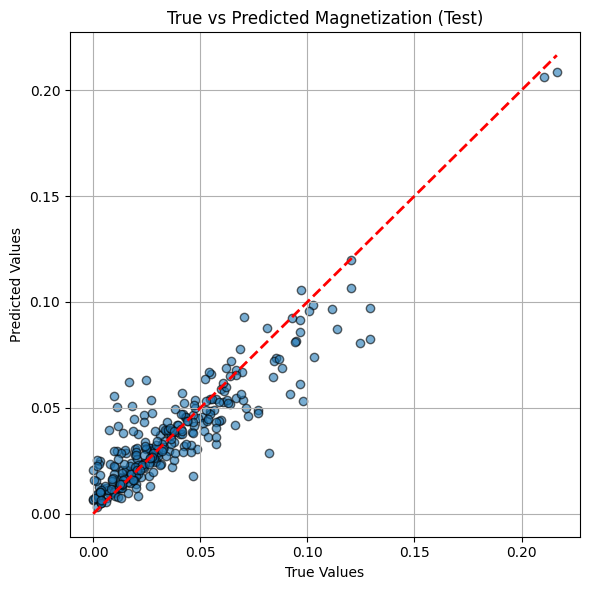

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import joblib


# --- Helper to create safe stratification bins ---
def make_safe_stratification_bins(y, min_per_bin=30, max_bins=10):
    """
    Bin continuous target values for stratification.
    Reduces bins until each has at least min_per_bin samples.
    """
    for n_bins in range(max_bins, 1, -1):
        try:
            discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
            y_binned = discretizer.fit_transform(y.reshape(-1, 1)).astype(int).ravel()
            _, counts = np.unique(y_binned, return_counts=True)
            if np.min(counts) >= min_per_bin:
                print(f"✅ Using {n_bins} bins for stratification (min bin size: {np.min(counts)})")
                return y_binned
        except:
            continue
    raise ValueError("❌ Cannot safely bin targets for stratification")

# --- Convert to NumPy arrays ---
X = np.array(X)
y = np.array(y)

# --- Create stratification bins ---
y_binned = make_safe_stratification_bins(y)

# --- First split: 60% train, 40% temp ---
X_train, X_temp, y_train, y_temp, yb_train, yb_temp = train_test_split(
    X, y, y_binned, test_size=0.2, random_state=42, stratify=y_binned
)

# --- Second split: 20% val, 20% test ---
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=yb_temp
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


#---------------COMPUTATIONAL STATS------------------------------------------------
def measure_rf_pipeline(X_train, y_train, X_test, rf_kwargs=None, sample_for_flop=0):
    rf_kwargs = rf_kwargs or {'n_estimators':200, 'random_state':42, 'n_jobs': -1}
    model = RandomForestRegressor(**rf_kwargs)

    # MEMORY snapshot before training
    cpu_mem_before = snapshot_cpu_mem()
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    t1 = time.perf_counter()
    cpu_mem_after = snapshot_cpu_mem()

    train_time_s = t1 - t0
    peak_mem_used_mb = max(cpu_mem_after - cpu_mem_before, 0.0)

    # Save or persist model
    joblib.dump(model, "rf_model.joblib")

    # Inference speed measurement (batch & per-sample)
    # warmup
    _ = model.predict(X_test[:10])
    t0 = time.perf_counter()
    y_pred = model.predict(X_test)
    t1 = time.perf_counter()
    inference_time_total = t1 - t0
    inference_time_per_sample = inference_time_total / len(X_test)

    # FLOP estimate (inference) using a single sample
    rf_flop_info = None
    try:
        rf_flop_info = estimate_rf_inference_flops(model, X_test[sample_for_flop if sample_for_flop else 0])
    except Exception as e:
        rf_flop_info = {'error': str(e)}

    results = {
        'train_time_s': train_time_s,
        'peak_cpu_mem_mb': peak_mem_used_mb,
        'inference_time_total_s': inference_time_total,
        'inference_time_per_sample_s': inference_time_per_sample,
        'rf_flop_info': rf_flop_info
    }
    return model, results

# example call
rf_model, rf_metrics = measure_rf_pipeline(X_train, y_train, X_test, rf_kwargs={'n_estimators':200,'n_jobs':-1,'random_state':42})
print(rf_metrics)



# --- Train model ---
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# --- Validation evaluation ---
y_val_pred = model.predict(X_val)
r2_val = r2_score(y_val, y_val_pred)
cc_val, _ = pearsonr(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

# --- Test evaluation ---
y_test_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
cc_test, _ = pearsonr(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("\n=== Results ===")
print(f"Validation -> R²: {r2_val:.4f}, CC: {cc_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test       -> R²: {r2_test:.4f}, CC: {cc_test:.4f}, MAE: {mae_test:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('True vs Predicted Magnetization (Test)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()



CGCNN

CG Construction

In [1]:
# train_cgcnn_instrumented.py
# Paste into a file and run with: python train_cgcnn_instrumented.py
# Requires: numpy, torch, sklearn, psutil (optional), thop (optional), pymatgen

import os, time, json, csv, functools, warnings, re, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from pymatgen.core import Element, Structure, Lattice
import psutil
from sklearn.metrics import r2_score, mean_absolute_error

# Optional FLOP profiler (install thop if you want exact counts)
try:
    from thop import profile
except Exception:
    profile = None

# ---------------------------
# ---------- CODE1 ----------
# ---------------------------
# (Your original CIFData + GaussianDistance)
class GaussianDistance(object):
    def __init__(self, dmin, dmax, step, var=None):
        assert dmin < dmax
        assert dmax - dmin > step
        self.filter = np.arange(dmin, dmax + step, step)
        self.var = step if var is None else var

    def expand(self, distances):
        return np.exp(-(distances[..., np.newaxis] - self.filter) ** 2 / self.var ** 2)


class CIFData(torch.utils.data.Dataset):
    def __init__(self, id_prop_path, magmom_path, eigen_path, ofm_val_comp_path,
                 max_num_nbr=12, radius=8, dmin=0, step=0.1, random_seed=123):
        # Load CSV
        with open(id_prop_path, newline='') as f:
            reader = csv.reader(f)
            self.id_prop_data = [row for row in reader]

        # Load magnetic moments
        with open(magmom_path) as f:
            self.magmom = json.load(f)

        # Load eigen (not used heavily here but kept)
        with open(eigen_path) as f:
            self.eigen1 = json.load(f)

        # Load OFM val components
        with open(ofm_val_comp_path) as f:
            self.ofm_val_comp = json.load(f)

        random.seed(random_seed)
        random.shuffle(self.id_prop_data)

        self.gdf = GaussianDistance(dmin=dmin, dmax=radius, step=step)
        self.max_num_nbr = max_num_nbr
        self.radius = radius

    def __len__(self):
        return len(self.id_prop_data)

    def structure_from_str(self, cif_string):
        cif_lines = cif_string.strip().split('\n')
        a, b, c = map(float, cif_lines[2].split()[2:5])
        alpha, beta, gamma = map(float, cif_lines[3].split()[1:4])
        species, coords = [], []
        reading_atoms = False
        for line in cif_lines:
            line = line.strip()
            if re.match(r'^\d+\s+\w+\s+[\d\.Ee+-]+\s+[\d\.Ee+-]+\s+[\d\.Ee+-]+', line):
                reading_atoms = True
            if not reading_atoms:
                continue
            try:
                parts = line.split()
                if len(parts) < 5:
                    continue
                sp = parts[1]
                a_frac, b_frac, c_frac = map(float, parts[2:5])
                species.append(sp)
                coords.append([a_frac, b_frac, c_frac])
            except Exception as e:
                warnings.warn(f"Skipping line due to error: {line} ({e})")
                continue
        lattice = Lattice.from_parameters(a, b, c, alpha, beta, gamma)
        return Structure(lattice, species, coords)

    def featurizer(self, element):
        min_max = [[1.00794, 244.0], [1.0, 118.0], [0.25, 2.6], [-0.72, 3.61272528]]
        lis = ['Atomic mass', 'Atomic no', 'Atomic radius', 'Electron affinity']
        ele = Element(element)
        try:
            fea = [float(str(ele.data[i]).split()[0]) for i in lis]
        except Exception:
            fea = [ele.data['Atomic mass'], ele.data['Atomic no'],
                   ele.data['Atomic radius calculated'], ele.data['Electron affinity']]
        for i in range(4):
            fea[i] = (fea[i] - min_max[i][0]) / (min_max[i][1] - min_max[i][0])
        return fea

    @functools.lru_cache(maxsize=None)
    def __getitem__(self, idx):
        cif_id, cif_string, target = self.id_prop_data[idx]
        crystal = self.structure_from_str(cif_string)
        atom_fea = np.vstack([
            [self.magmom[site.species_string]] + self.ofm_val_comp[site.species_string]
            + self.featurizer(site.species_string)
            for site in crystal
        ])
        atom_fea = torch.Tensor(atom_fea)
        all_nbrs = crystal.get_all_neighbors(self.radius, include_index=True)
        all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]
        nbr_fea_idx, nbr_fea = [], []
        for i, nbr in enumerate(all_nbrs):
            if len(nbr) < self.max_num_nbr:
                warnings.warn(f'{cif_id} atom {i} has only {len(nbr)} neighbors. Consider increasing radius.')
                nbr_fea_idx.append([x[2] for x in nbr] + [0] * (self.max_num_nbr - len(nbr)))
                nbr_fea.append([x[1] for x in nbr] + [self.radius + 1.] * (self.max_num_nbr - len(nbr)))
            else:
                nbr_fea_idx.append([x[2] for x in nbr[:self.max_num_nbr]])
                nbr_fea.append([x[1] for x in nbr[:self.max_num_nbr]])
        nbr_fea_idx = torch.LongTensor(nbr_fea_idx)
        nbr_fea = torch.Tensor(self.gdf.expand(np.array(nbr_fea)))
        target = torch.Tensor([float(target)])
        return (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id

CNN Construction

In [2]:
# ---------- CODE2 ----------
# ---------------------------
# collate_pool + model classes (unchanged behavior)
def collate_pool(batch):
    batch_atom_fea, batch_nbr_fea, batch_nbr_fea_idx = [], [], []
    crystal_atom_idx, batch_target = [], []
    base_idx = 0
    for (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id in batch:
        n_i = atom_fea.shape[0]
        batch_atom_fea.append(atom_fea)
        batch_nbr_fea.append(nbr_fea)
        batch_nbr_fea_idx.append(nbr_fea_idx + base_idx)
        crystal_atom_idx.append(torch.arange(n_i) + base_idx)
        batch_target.append(target)
        base_idx += n_i
    return (torch.cat(batch_atom_fea, dim=0),
            torch.cat(batch_nbr_fea, dim=0),
            torch.cat(batch_nbr_fea_idx, dim=0),
            crystal_atom_idx), torch.stack(batch_target, dim=0)

class ConvLayer(nn.Module):
    def __init__(self, atom_fea_len, nbr_fea_len):
        super(ConvLayer, self).__init__()
        self.fc_full = nn.Linear(2*atom_fea_len + nbr_fea_len, 2*atom_fea_len)
        self.sigmoid = nn.Sigmoid()
        self.softplus1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(2*atom_fea_len)
        self.bn2 = nn.BatchNorm1d(atom_fea_len)
        self.softplus2 = nn.ReLU()

    def forward(self, atom_fea, nbr_fea, nbr_idx):
        N, M = nbr_idx.shape
        atom_nbr_fea = atom_fea[nbr_idx]
        total_nbr_fea = torch.cat([atom_fea.unsqueeze(1).expand(-1,M,-1), atom_nbr_fea, nbr_fea], dim=2)
        total_gated = self.fc_full(total_nbr_fea)
        total_gated = self.bn1(total_gated.view(-1, total_gated.shape[-1])).view(N,M,-1)
        nbr_filter, nbr_core = total_gated.chunk(2, dim=2)
        nbr_filter = self.sigmoid(nbr_filter)
        nbr_core = self.softplus1(nbr_core)
        nbr_sumed = torch.sum(nbr_filter * nbr_core, dim=1)
        nbr_sumed = self.bn2(nbr_sumed)
        return self.softplus2(atom_fea + nbr_sumed)

class CrystalGraphNet(nn.Module):
    def __init__(self, orig_atom_fea_len, nbr_fea_len, atom_fea_len=64, n_conv=4, h_fea_len=92, n_h=4):
        super(CrystalGraphNet, self).__init__()
        self.embedding = nn.Linear(orig_atom_fea_len, atom_fea_len)
        self.convs = nn.ModuleList([ConvLayer(atom_fea_len, nbr_fea_len) for _ in range(n_conv)])
        self.fc1 = nn.Linear(atom_fea_len, h_fea_len)
        self.fcs = nn.ModuleList([nn.Linear(h_fea_len, h_fea_len) for _ in range(n_h-1)])
        self.softplus = nn.ReLU()
        self.out = nn.Linear(h_fea_len, 1)

    def pooling(self, atom_fea, crystal_atom_idx):
        return torch.cat([torch.mean(atom_fea[idx], dim=0, keepdim=True) for idx in crystal_atom_idx], dim=0)

    def forward(self, atom_fea, nbr_fea, nbr_idx, crystal_atom_idx):
        atom_fea = self.embedding(atom_fea)
        for conv in self.convs:
            atom_fea = conv(atom_fea, nbr_fea, nbr_idx)
        crys_fea = self.pooling(atom_fea, crystal_atom_idx)
        crys_fea = self.softplus(self.fc1(crys_fea))
        for fc in self.fcs:
            crys_fea = self.softplus(fc(crys_fea))
        return self.out(crys_fea)


Model Training and Testing

In [ ]:

# ---------------------------
# ---------- CODE3----------
# ---------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Helper for binning
def make_safe_stratification_bins(y, min_per_bin=30, max_bins=10):
    for n_bins in range(max_bins, 1, -1):
        try:
            discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
            y_binned = discretizer.fit_transform(y.reshape(-1, 1)).astype(int).ravel()
            _, counts = np.unique(y_binned, return_counts=True)
            if np.min(counts) >= min_per_bin:
                print(f"✅ Using {n_bins} bins for stratification (min bin size: {np.min(counts)})")
                return y_binned
        except Exception:
            continue
    raise ValueError("❌ Could not bin targets adequately for stratification.")

# ---------- PARAMETERS ----------
id_prop_path = 'my_new_data1/co_fm.csv'
magmom_path = 'my_new_data1/magmom.json'
eigen_path = 'my_new_data1/eigenvalues_bulk.json'
ofm_path = 'my_new_data1/ofm.json'
batch_size = 32
max_epochs = 30
random_seed = 42
# -------------------------------

# Load dataset (user provided)
dataset = CIFData(id_prop_path=id_prop_path, magmom_path=magmom_path,
                  eigen_path=eigen_path, ofm_val_comp_path=ofm_path)

# create strat bins
targets = torch.stack([dataset[i][1] for i in range(len(dataset))]).numpy()
y_binned = make_safe_stratification_bins(targets)

# 60/20/20 split (same as original)
train_idx, temp_idx, _, temp_bins = train_test_split(
    np.arange(len(dataset)), y_binned, test_size=0.6, stratify=y_binned, random_state=random_seed
)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=temp_bins, random_state=random_seed)
print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True, collate_fn=collate_pool)
val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False, collate_fn=collate_pool)
test_loader  = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False, collate_fn=collate_pool)

# model init (CPU)
(atom_fea, nbr_fea, nbr_idx, _), _ = next(iter(train_loader))
model = CrystalGraphNet(atom_fea.shape[1], nbr_fea.shape[2])
device = torch.device('cpu')
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1)

# Optional: FLOP profiling (single-batch)
avg_atoms_in_sample = (atom_fea.shape[0] / len(train_loader)) if len(train_loader)>0 else atom_fea.shape[0]
if profile is not None:
    try:
        print("Running FLOP profile (thop) on one batch - this may take a moment...")
        flops, params = profile(model, inputs=(atom_fea.float(), nbr_fea.float(), nbr_idx, _), verbose=False)
        # estimate per-sample flops: divide by number of crystals in that batch
        n_crystals_in_batch = len(_)
        per_sample_flops = flops / n_crystals_in_batch if n_crystals_in_batch>0 else flops
        print(f"thop -> flops(batch)={flops}, params={params}, per_sample_est={per_sample_flops}")
    except Exception as e:
        print("thop profiling failed:", e)
else:
    print("thop not available; skipping detailed FLOP profiling. Install with: pip install thop")

# -------- Training with instrumentation --------
proc = psutil.Process(os.getpid())
training_start = time.time()
epoch_times = []
peak_rss = 0
best_val_loss = float('inf')
patience = 8
patience_counter = 0

for epoch in range(max_epochs):
    t0_epoch = time.time()
    model.train()
    total_loss = 0.0
    for (atom_fea, nbr_fea, nbr_idx, crystal_atom_idx), targets in train_loader:
        # sample memory
        try:
            rss = proc.memory_info().rss
            if rss > peak_rss:
                peak_rss = rss
        except Exception:
            pass

        optimizer.zero_grad()
        outputs = model(atom_fea.float(), nbr_fea.float(), nbr_idx.long(), crystal_atom_idx)
        loss = criterion(outputs.view(-1), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    epoch_time = time.time() - t0_epoch
    epoch_times.append(epoch_time)
    avg_train_loss = total_loss / len(train_loader)

    # Validation (timed)
    val_start = time.time()
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (atom_fea, nbr_fea, nbr_idx, crystal_atom_idx), targets in val_loader:
            outputs = model(atom_fea.float(), nbr_fea.float(), nbr_idx.long(), crystal_atom_idx)
            val_loss += criterion(outputs.view(-1), targets.view(-1)).item()
    val_time = time.time() - val_start
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch}: Train={avg_train_loss:.6f}, Val={avg_val_loss:.6f}, epoch_s={epoch_time:.3f}, val_s={val_time:.3f}")

    # checkpoint + early stop
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'epoch_times': epoch_times
        }
        torch.save(checkpoint, 'checkpoint_full.pt')
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping at epoch", epoch)
            break

training_total = time.time() - training_start
peak_cpu_mem_mb = peak_rss / (1024.0**2) if peak_rss else None
print("Training total time (s):", training_total)
print("Peak CPU memory (MB):", peak_cpu_mem_mb)

# ===== Evaluation with timing =====
def evaluate_timed(loader):
    y_true, y_pred = [], []
    t0 = time.time()
    with torch.no_grad():
        for (atom_fea, nbr_fea, nbr_idx, crystal_atom_idx), targets in loader:
            outputs = model(atom_fea.float(), nbr_fea.float(), nbr_idx.long(), crystal_atom_idx)
            y_true.extend(targets.view(-1).numpy())
            y_pred.extend(outputs.view(-1).numpy())
    total_time = time.time() - t0
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    per_sample = total_time / len(y_true) if len(y_true)>0 else None
    metrics = {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "CC": pearsonr(y_true, y_pred)[0],
        "total_time_s": total_time,
        "time_per_sample_s": per_sample
    }
    return metrics, y_true, y_pred

val_metrics, _, _ = evaluate_timed(val_loader)
test_metrics, y_true_test, y_pred_test = evaluate_timed(test_loader)
print("\nValidation metrics:", val_metrics)
print("Test metrics:", test_metrics)

# Save metrics to JSON + CSV for paper
metrics_summary = {
    'training_total_time_s': training_total,
    'epoch_times_s': epoch_times,
    'peak_cpu_mem_mb': peak_cpu_mem_mb,
    'val_metrics': val_metrics,
    'test_metrics': test_metrics
}
import numpy as np
import json

def np_encoder(obj):
    if isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    return obj

with open('cgcnn_run_metrics.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2, default=np_encoder)

print("Saved cgcnn_run_metrics.json")

# Simple CSV summary (for table)
import csv as _csv
with open('cgcnn_run_metrics_summary.csv', 'w', newline='') as cf:
    w = _csv.writer(cf)
    w.writerow(['metric','value'])
    w.writerow(['training_total_time_s', training_total])
    w.writerow(['peak_cpu_mem_mb', peak_cpu_mem_mb])
    w.writerow(['val_R2', val_metrics['R2']])
    w.writerow(['val_MAE', val_metrics['MAE']])
    w.writerow(['test_R2', test_metrics['R2']])
    w.writerow(['test_MAE', test_metrics['MAE']])
    w.writerow(['test_inference_total_s', test_metrics['total_time_s']])
    w.writerow(['test_inference_time_per_sample_s', test_metrics['time_per_sample_s']])
print("Saved cgcnn_run_metrics_summary.csv")

# Scatter plot (test)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y_true_test, y_pred_test, alpha=0.6, edgecolors='k', linewidth=0.2)
mn = min(y_true_test.min(), y_pred_test.min()); mx = max(y_true_test.max(), y_pred_test.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
plt.xlabel('True Magnetization'); plt.ylabel('Predicted Magnetization')
plt.title('CGCNN: True vs Predicted (Test)')
plt.grid(True)
plt.tight_layout()
plt.savefig('cgcnn_true_vs_pred_test.png', dpi=300)
plt.close()
print("Saved cgcnn_true_vs_pred_test.png")

# Done
print("All done. Files saved: checkpoint_full.pt, best_model.pt, cgcnn_run_metrics.json, cgcnn_run_metrics_summary.csv, cgcnn_true_vs_pred_test.png")


✅ Using 10 bins for stratification (min bin size: 294)
Train: 1177, Val: 883, Test: 884
Running FLOP profile (thop) on one batch - this may take a moment...
thop profiling failed: tensors used as indices must be long, int, byte or bool tensors
Epoch 0: Train=0.002182, Val=0.000601, epoch_s=7.519, val_s=1.789
Epoch 1: Train=0.000398, Val=0.000360, epoch_s=9.337, val_s=1.755
Epoch 2: Train=0.000387, Val=0.001840, epoch_s=9.156, val_s=1.832
Epoch 3: Train=0.000272, Val=0.000277, epoch_s=8.941, val_s=1.714
Epoch 4: Train=0.000245, Val=0.000707, epoch_s=8.838, val_s=1.768
Epoch 5: Train=0.000208, Val=0.000256, epoch_s=9.379, val_s=1.575
Epoch 6: Train=0.000203, Val=0.000220, epoch_s=9.095, val_s=1.743
Epoch 7: Train=0.000175, Val=0.000235, epoch_s=9.462, val_s=1.499
Epoch 8: Train=0.000165, Val=0.000195, epoch_s=9.192, val_s=1.873
Epoch 9: Train=0.000181, Val=0.000236, epoch_s=9.059, val_s=1.665
Epoch 10: Train=0.000182, Val=0.000316, epoch_s=8.900, val_s=1.749
Epoch 11: Train=0.000182, Val

KeyboardInterrupt: 